# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from collections import deque
from importlib import reload

from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from workspace_utils import active_session

import ddpg_agent

In [2]:
#env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")
#nv = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64") # not working on ubuntu 18.04

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [4]:
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size

print(f"num_agents {num_agents}, state_size: {state_size}, action_size: {action_size}")

num_agents 2, state_size: 24, action_size: 2


In [5]:
reload(ddpg_agent)

agent = ddpg_agent.Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)

print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=402, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


In [6]:
def ddpg(n_episodes=5000):
    scores_deque = deque(maxlen=100)
    scores = []
    best_avg_score = 0.
    solved = False
    pbar = tqdm(range(1, n_episodes+1))
    for i_episode in pbar:
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = 0
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.mean(rewards)
            if np.any(dones):
                break
        scores_deque.append(score)
        scores.append(score)
        pbar.set_description('Average Score: {:.3f}, Score: {:.3f}'.format(np.mean(scores_deque), score))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > best_avg_score:
            best_avg_score = np.mean(scores_deque)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_best.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_best.pth')
        if not solved and np.mean(scores_deque) >= 0.8:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_solved.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_solved.pth')
    pbar.close()
    return scores

In [7]:
with active_session():
    scores = ddpg(n_episodes=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]/mnt/work/dev/udacity/deep-reinforcement-learning/.venv/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Average Score: -0.004, Score: -0.005:   2%|▏         | 100/5000 [01:28<1:38:06,  1.20s/it]

Episode 100	Average Score: -0.004


Average Score: -0.005, Score: -0.005:   4%|▍         | 200/5000 [03:27<1:34:31,  1.18s/it]

Episode 200	Average Score: -0.005


Average Score: -0.005, Score: -0.005:   6%|▌         | 300/5000 [05:25<1:31:53,  1.17s/it]

Episode 300	Average Score: -0.005


Average Score: -0.005, Score: -0.005:   8%|▊         | 400/5000 [07:23<1:30:34,  1.18s/it]

Episode 400	Average Score: -0.005


Average Score: -0.005, Score: -0.005:  10%|█         | 500/5000 [09:22<1:28:23,  1.18s/it]

Episode 500	Average Score: -0.005


Average Score: -0.004, Score: -0.005:  12%|█▏        | 600/5000 [11:23<1:27:57,  1.20s/it]

Episode 600	Average Score: -0.004


Average Score: -0.005, Score: -0.005:  14%|█▍        | 700/5000 [13:24<1:26:08,  1.20s/it]

Episode 700	Average Score: -0.005


Average Score: -0.005, Score: -0.005:  16%|█▌        | 800/5000 [15:24<1:24:27,  1.21s/it]

Episode 800	Average Score: -0.005


Average Score: -0.005, Score: -0.005:  18%|█▊        | 900/5000 [17:26<1:22:34,  1.21s/it]

Episode 900	Average Score: -0.005


Average Score: -0.005, Score: -0.005:  20%|██        | 1000/5000 [19:29<1:25:14,  1.28s/it]

Episode 1000	Average Score: -0.005


Average Score: 0.004, Score: -0.005:  22%|██▏       | 1100/5000 [22:01<1:19:32,  1.22s/it] 

Episode 1100	Average Score: 0.004


Average Score: -0.005, Score: -0.005:  24%|██▍       | 1200/5000 [24:02<1:17:01,  1.22s/it]

Episode 1200	Average Score: -0.005


Average Score: -0.005, Score: -0.005:  26%|██▌       | 1300/5000 [26:04<1:14:47,  1.21s/it]

Episode 1300	Average Score: -0.005


Average Score: 0.011, Score: -0.005:  28%|██▊       | 1400/5000 [29:00<6:47:38,  6.79s/it] 

Episode 1400	Average Score: 0.011


Average Score: 0.020, Score: -0.005:  30%|███       | 1500/5000 [32:25<1:53:48,  1.95s/it]

Episode 1500	Average Score: 0.020


Average Score: 0.039, Score: 0.045:  32%|███▏      | 1600/5000 [36:47<2:30:47,  2.66s/it] 

Episode 1600	Average Score: 0.039


Average Score: 0.119, Score: 0.095:  34%|███▍      | 1700/5000 [45:59<8:07:37,  8.87s/it]  

Episode 1700	Average Score: 0.119


Average Score: 0.325, Score: 0.095:  36%|███▌      | 1800/5000 [1:06:55<13:37:22, 15.33s/it]

Episode 1800	Average Score: 0.325


Average Score: 0.291, Score: -0.005:  38%|███▊      | 1900/5000 [1:26:44<2:34:53,  3.00s/it] 

Episode 1900	Average Score: 0.291


Average Score: 0.107, Score: 0.645:  40%|████      | 2000/5000 [1:35:47<10:44:18, 12.89s/it]

Episode 2000	Average Score: 0.107


Average Score: 0.131, Score: 0.095:  42%|████▏     | 2100/5000 [1:46:06<2:55:40,  3.63s/it]  

Episode 2100	Average Score: 0.131


Average Score: 0.432, Score: 0.195:  44%|████▍     | 2200/5000 [2:13:30<4:29:47,  5.78s/it]  

Episode 2200	Average Score: 0.432


Average Score: 0.216, Score: 0.195:  46%|████▌     | 2300/5000 [2:28:33<4:20:03,  5.78s/it]  

Episode 2300	Average Score: 0.216


Average Score: 0.111, Score: 0.145:  48%|████▊     | 2400/5000 [2:37:30<4:47:36,  6.64s/it] 

Episode 2400	Average Score: 0.111


Average Score: 0.124, Score: 0.445:  50%|█████     | 2500/5000 [2:48:13<7:02:17, 10.13s/it]  

Episode 2500	Average Score: 0.124


Average Score: 0.277, Score: 0.795:  52%|█████▏    | 2600/5000 [3:06:48<13:57:05, 20.93s/it] 

Episode 2600	Average Score: 0.277


Average Score: 0.243, Score: -0.005:  54%|█████▍    | 2700/5000 [3:23:15<4:45:10,  7.44s/it] 

Episode 2700	Average Score: 0.243


Average Score: 0.162, Score: -0.005:  56%|█████▌    | 2800/5000 [3:34:58<2:01:09,  3.30s/it]

Episode 2800	Average Score: 0.162


Average Score: 0.243, Score: 0.395:  58%|█████▊    | 2900/5000 [3:51:35<7:04:11, 12.12s/it]  

Episode 2900	Average Score: 0.243


Average Score: 0.741, Score: -0.005:  60%|██████    | 3000/5000 [4:37:38<20:22:40, 36.68s/it]

Episode 3000	Average Score: 0.741


Average Score: 0.804, Score: 2.600:  60%|██████    | 3018/5000 [4:49:58<40:07:03, 72.87s/it] 


Environment solved in 2918 episodes!	Average Score: 0.804


Average Score: 0.825, Score: 0.045:  62%|██████▏   | 3100/5000 [5:31:06<15:24:22, 29.19s/it] 

Episode 3100	Average Score: 0.825


Average Score: 0.550, Score: 0.995:  64%|██████▍   | 3200/5000 [6:06:54<13:26:29, 26.88s/it] 

Episode 3200	Average Score: 0.550


Average Score: 0.741, Score: -0.005:  66%|██████▌   | 3300/5000 [6:56:29<6:45:49, 14.32s/it] 

Episode 3300	Average Score: 0.741


Average Score: 0.531, Score: 0.495:  68%|██████▊   | 3400/5000 [7:33:46<7:57:32, 17.91s/it]  

Episode 3400	Average Score: 0.531


Average Score: 0.361, Score: 0.495:  70%|███████   | 3500/5000 [8:00:51<11:03:01, 26.52s/it] 

Episode 3500	Average Score: 0.361


Average Score: 0.385, Score: 0.395:  72%|███████▏  | 3600/5000 [8:29:32<7:11:33, 18.50s/it]  

Episode 3600	Average Score: 0.385


Average Score: 0.482, Score: 0.595:  74%|███████▍  | 3700/5000 [9:05:46<7:23:33, 20.47s/it]  

Episode 3700	Average Score: 0.482


Average Score: 0.419, Score: 0.095:  76%|███████▌  | 3800/5000 [9:37:30<5:20:16, 16.01s/it]  

Episode 3800	Average Score: 0.419


Average Score: 0.561, Score: 0.095:  78%|███████▊  | 3900/5000 [10:19:09<8:24:57, 27.54s/it]  

Episode 3900	Average Score: 0.561


Average Score: 0.561, Score: -0.005:  80%|████████  | 4000/5000 [11:02:47<3:25:58, 12.36s/it] 

Episode 4000	Average Score: 0.561


Average Score: 0.544, Score: 0.245:  82%|████████▏ | 4100/5000 [11:47:04<10:40:47, 42.72s/it] 

Episode 4100	Average Score: 0.544


Average Score: 0.551, Score: 0.895:  84%|████████▍ | 4200/5000 [12:31:33<5:02:29, 22.69s/it]  

Episode 4200	Average Score: 0.551


Average Score: 0.897, Score: 2.445:  86%|████████▌ | 4300/5000 [13:44:09<15:19:52, 78.85s/it] 

Episode 4300	Average Score: 0.897


Average Score: 0.704, Score: 1.245:  88%|████████▊ | 4400/5000 [14:44:29<5:48:22, 34.84s/it]  

Episode 4400	Average Score: 0.704


Average Score: 0.470, Score: 1.095:  90%|█████████ | 4500/5000 [15:26:41<5:47:02, 41.65s/it] 

Episode 4500	Average Score: 0.470


Average Score: 0.635, Score: -0.005:  92%|█████████▏| 4600/5000 [16:22:34<5:07:18, 46.10s/it]

Episode 4600	Average Score: 0.635


Average Score: 0.730, Score: 0.295:  94%|█████████▍| 4700/5000 [17:27:01<1:55:15, 23.05s/it] 

Episode 4700	Average Score: 0.730


Average Score: 0.754, Score: 1.095:  96%|█████████▌| 4800/5000 [18:32:50<2:00:32, 36.16s/it] 

Episode 4800	Average Score: 0.754


Average Score: 0.587, Score: -0.005:  98%|█████████▊| 4900/5000 [19:23:38<26:35, 15.95s/it]  

Episode 4900	Average Score: 0.587


Average Score: 0.619, Score: 2.600: 100%|██████████| 5000/5000 [20:16:37<00:00, 14.60s/it]  

Episode 5000	Average Score: 0.619


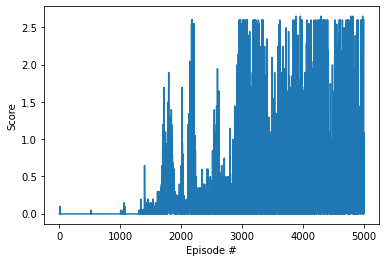

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [9]:
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size

print(f"num_agents {num_agents}, state_size: {state_size}, action_size: {action_size}")

num_agents 2, state_size: 24, action_size: 2


In [10]:
agent = ddpg_agent.Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor_solved.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_solved.pth'))

print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=402, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


In [11]:
all_scores = []

for _ in range(5):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)                        # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if any episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if any episode finished
            break
    print("Score over all agents in this episode: avg: {:.3f}, max: {:.3f}, min: {:.3f}".format(
        np.mean(scores), np.max(scores), np.min(scores)
    ))
    all_scores.append(scores)

print("Score over all agents in all episodes: avg: {:.3f}, max: {:.3f}, min: {:.3f}".format(
    np.mean(all_scores), np.max(all_scores), np.min(all_scores)
))

/mnt/work/dev/udacity/deep-reinforcement-learning/.venv/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Score over all agents in this episode: avg: 0.795, max: 0.800, min: 0.790
Score over all agents in this episode: avg: 2.445, max: 2.500, min: 2.390
Score over all agents in this episode: avg: 1.295, max: 1.300, min: 1.290
Score over all agents in this episode: avg: -0.005, max: 0.000, min: -0.010
Score over all agents in this episode: avg: 1.345, max: 1.400, min: 1.290
Score over all agents in all episodes: avg: 1.175, max: 2.500, min: -0.010
